In [41]:
%pylab inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import geom
import copy
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from ABC_functions import *
PLOTDIR_DEFAULT = '/storage/BonnieH/selection_project/ashg/source_images_0929/'

Populating the interactive namespace from numpy and matplotlib


In [42]:
# Functions for mutation model, selection model, and simulation algorithm 

########## Imports ##########

def Plot(num_alleles, allele_freqs, fig_num, plotdir, gens):
    fig = plt.figure(fig_num)
    ax = fig.add_subplot(111)
    ax.bar(list(range(-1*int(num_alleles/2), int(num_alleles/2)+1)), allele_freqs)
    #ax.set_title('Chr %s start %d \n Heterozygosity: %.3f'%(chrom, start,obs_het),size=15)
    #ax.set_xlabel("Allele",size=15, fontname="Arial")
    #ax.set_ylabel("Frequency",size=15, fontname="Arial")
    plt.ylim(0,1.15)
    #plt.xticks(fontsize=15, fontname="Arial") 
    #plt.yticks(fontsize=15, fontname="Arial")
    #ax.tick_params(labelbottom=False)    
    #ax.tick_params(labelleft=False)    
    plt.xticks([])
    plt.yticks([])
    fig_num_string = str(fig_num)
    if fig_num < 10:
        fig_num_string = '0'+str(fig_num)
    if gens != -1:
        plt.text(-13, 1.05, 'Simulating for t=%d generations'%(gens), fontsize=12)
    
    if fig_num == 1:
        plt.ylim(0,0.7)
        plt.savefig(plotdir + '%s.png'%(fig_num_string), bbox_inches='tight')

########## Simulation Helper Functions ##########

def GetStepSizeProb(a1, a2, beta, p):
    step_size = (a2-a1)
    up_prob = max([0.01,0.5*(1-beta*p*a1)]) # Minimum value is 0.01
    up_prob = min(up_prob, 0.99) # Maximum value is 0.99
    down_prob = 1-up_prob
    if step_size>0: dir_prob = up_prob
    else: dir_prob = down_prob
    step_prob = geom.pmf(abs(step_size), p)
    return dir_prob*step_prob

"""Build transition matrix 

Parameters
----------
num_alleles : int
    Size of transition matrix to build. Centered at "0" (most optimal allele in the center)
mu: float
beta: float 
p: float
L: float
    
Returns
-------
transition_matrix: numpy.ndarray object
    Matrix of transition probabilities
"""
def GetTransitionMatrix(num_alleles, mu, beta, p, L):
    # Initialize matrix (optimal=0)
    transition_matrix = np.zeros((num_alleles, num_alleles))

    # Fill in probability to transition from a1 to a2
    for i in range(num_alleles):
        for j in range(num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
            log_mu_prime = np.log10(mu)+L*a1 # Length-dependent mutation rate. TODO should we do a sigmoid curve like Payseur?
            mu_prime = 10**log_mu_prime
            if mu_prime < 10**-8: mu_prime = 10**-8 
            if mu_prime > 10**-3: mu_prime = 10**-3
            if a1==a2: transition_matrix[i,j] = 1-mu_prime
            else:
                prob = GetStepSizeProb(a1, a2, beta, p)
                transition_matrix[i,j] = mu_prime*prob
        
    # Rescale each row to sum to 1 (which should hopefully be mostly true anyway)
    for i in range(num_alleles):
        rowsum = np.sum(transition_matrix[i,:])
        transition_matrix[i,:] = transition_matrix[i,:]/rowsum

    return transition_matrix

"""Build fitness matrix (fitness of each genotype) 

Parameters
----------
num_alleles : int
    Size of fitness matrix to build. Centered at "0" (most optimal allele in the center)
s: float
    Selection coefficient. Most fit allele has relative fitness 1. Next most has 1-s, next most has 1-2s, etc.
is_w_additive: bool
    Whether the fitness of genotypes is calculated under an additive or multiplicative model
    
Returns
-------
fitness_matrix: numpy.ndarray object
    Matrix of fitness values
"""
def GetFitnessMatrix(num_alleles, s, is_w_additive):
    fitness_matrix = np.zeros((num_alleles, num_alleles))
    for i in range (0, num_alleles):
        for j in range (0, num_alleles):
            a1 = -1*int(num_alleles/2)+i
            a2 = -1*int(num_alleles/2)+j
           
            # Get fitness of each allele
            w_a1 = 1-abs(a1)*s #np.exp(-1*abs(a1)*s) Chance allele won't die, higher w = higher fitness
            w_a2 = 1-abs(a2)*s #np.exp(-1*abs(a2)*s) Chance allele won't die, higher w = higher fitness
            
            # Genotype fitness cannot be less than 0
            if is_w_additive == True:
                fitness_matrix[i,j] = max(0, w_a1/2 + w_a2/2)
                
            if is_w_additive == False:
                fitness_matrix[i,j] = max(0, w_a1*w_a2)
                
    return fitness_matrix

"""Get marginal fitness vector

Parameters
----------
allele_freqs : numpy.ndarray object
    1 x n matrix
fitness matrix: numpy.ndarray object
    n x n matrix
    
Returns
-------
marginal_fitness_vector: numpy.ndarray object
    1 x n matrix, where the marginal fitness of allele i = sum(p[j]w[i,j]) for all alleles j
"""
def GetMarginalFitnessVector(allele_freqs, fitness_matrix):
    return np.matmul(fitness_matrix, allele_freqs)
    
### Build gradient vector of partial derivatives of mean fitness with respect to each p[i] ###
# Partial derivative with respect with p[i] is equal to twice the marginal fitness of allele a[i]
def GetGradient(marginal_fitness_vector):
    return 2*marginal_fitness_vector
    
### Get mean fitness ###
# Sum of genotypic fitnesses weighted by corresponding genotype frequency
def GetMeanFitness(marginal_fitness_vector, allele_freqs):
    return np.dot(marginal_fitness_vector, allele_freqs)

### Build covariance matrix ###
def GetCovarianceMatrix(allele_freqs):
    
    allele_freqs_matrix = np.reshape(allele_freqs, (1,len(allele_freqs)))
    allele_freqs_matrix_trans = np.reshape(allele_freqs, (len(allele_freqs),1))
    
    # Fill in off-diagonal elements C[i,j] = -p[i]p[j]/2 (divison by 2 not included here)
    covariance_matrix = np.matmul(allele_freqs_matrix_trans, -1*allele_freqs_matrix)
    
    # Fill in diagonal elements C[i,i] = p[i](1-p[i])/2 (division by 2 not included here)
    for i in range(0, len(allele_freqs)):
        covariance_matrix.itemset((i,i),allele_freqs[i]*(1-allele_freqs[i]))
        
    return covariance_matrix

"""Simulate equilibrium allele frequencies

Parameters
----------
num_alleles : int
    Number of alleles included in simulation   
N_e: int
    Effective population size
mu: float
    Per-generation mutation rate of the central allele
beta: float
    Strength of mutation size directional bias
p: float
    Parameterizes the mutation geometric step size distribution
L: float
    Length-dependent mutation rate parameter (slope of the increase of mutation rate with allele size)
s: float
    Selection coefficient. 
max_iter: int
    Number of generations to perform forward simulations (including the additional 6k generations from incorporating European demographic model)
end_samp_n: int
    Sample size for observed allele frequencies for last sampling step
return_stats: bool
    Whether to return vectors of heterozygosity and variance over time
use_drift: bool
    Whether to perform multinomial sampling step at each generation
set_start_equal: bool
    Whether to set starting vector of allele frequencies as equal
"""
def Simulate(num_alleles, N_e, mu, beta, p, L, s, max_iter, end_samp_n, return_stats=False, use_drift=True, set_start_equal=False):

    PARAM_is_w_additive = True # Whether the fitness matrix of genotypes is additive or multiplicative

    allele_freqs = np.zeros(num_alleles)
    const = 5188
    allele_freqs[int(num_alleles/2)] = 4805/const
    allele_freqs[int(num_alleles/2)-1] = 5/const
    allele_freqs[int(num_alleles/2)-2] = 4/const
    allele_freqs[int(num_alleles/2)-3] = 73/const
    allele_freqs[int(num_alleles/2)+1] = 297/const
    allele_freqs[int(num_alleles/2)+2] = 4/const
    
    
    
   
    allele_freqs = np.zeros(num_alleles)
    const = 6510
    allele_freqs[int(num_alleles/2)] = 3686/const
    allele_freqs[int(num_alleles/2)-1] = 2052/const
    allele_freqs[int(num_alleles/2)-3] = 475/const
    allele_freqs[int(num_alleles/2)+1] = 33/const
    allele_freqs[int(num_alleles/2)+2] = 8/const
    allele_freqs[int(num_alleles/2)+3] = 238/const
    allele_freqs[int(num_alleles/2)+4] = 15/const
    allele_freqs[int(num_alleles/2)+5] = 3/const

    Plot(num_alleles, allele_freqs, 1, '', -1)
    # Set the starting vector of allele frequencies 
    allele_freqs = np.zeros(num_alleles)
    
    # Set starting vector of allele frequencies: All alleles equal frequencies
    if set_start_equal == True:
        for i in range(num_alleles):
            allele_freqs[i] = 1/num_alleles

    # Set starting vector of allele frequencies: Optimal allele frequency 1
    if set_start_equal == False:
        allele_freqs[int(num_alleles/2)] = 1

    # Get transition matrix (constant)
    transition_matrix = GetTransitionMatrix(num_alleles, mu, beta, p, L)
    
    # Transpose transition matrix
    transition_matrix_transpose = transition_matrix.transpose()

    # Calculate fitness matrix for each allele pair (genotype)
    fitness_matrix = GetFitnessMatrix(num_alleles, s, PARAM_is_w_additive)
    
    t = 0 # Number of iterations of while loop

    het_list = []
    var_list = []
    allele_freqs_20k = np.zeros(num_alleles)
    allele_freqs_50k = np.zeros(num_alleles)
    fig_num = 1
    while t < max_iter:
        
        if t%1000 == 0:
            fig_num = fig_num + 1
            Plot(num_alleles, allele_freqs, fig_num, PLOTDIR_DEFAULT, t)
            
        if return_stats == True and t % 100 == 0 and t < max_iter - 5920:
            het = 1-sum([item**2 for item in allele_freqs])
            het_list.append(het)
            var = GetVar(allele_freqs)
            var_list.append(var)
            
        # Get allele frequencies at 20k generations
        if t == 20000:
            allele_freqs_20k = copy.deepcopy(allele_freqs)
            if end_samp_n > 0:
                allele_counts = np.random.multinomial(end_samp_n, allele_freqs_20k)

                # Rescale allele_freqs to sum to 1
                rowsum = np.sum(allele_counts)

                allele_freqs_20k = allele_counts/rowsum

        # Get allele frequencies before incorporating European demographics 
        if t == 50000: 
            allele_freqs_50k = copy.deepcopy(allele_freqs)
            if end_samp_n > 0:
                allele_counts = np.random.multinomial(end_samp_n, allele_freqs_50k)

                # Rescale allele_freqs to sum to 1
                rowsum = np.sum(allele_counts)

                allele_freqs_50k = allele_counts/rowsum
            
        # European demographic model
        if t == max_iter - 5920:
            N_e = 14474
        
        if t == max_iter - 2040:
            N_e = 1861
            
        if t == max_iter - 920:
            N_e = 1032
        
        if t > max_iter - 920 and t < max_iter - 205:
            N_e = N_e * 1.00307
        
        if t >= max_iter - 205:
            N_e = N_e * 1.0195
            
        # Calculate marginal fitness w*(a[i]) for each allele
        marginal_fitness_vector = GetMarginalFitnessVector(allele_freqs, fitness_matrix)

        # Calculate gradient vector of partial derivatives of mean fitness
        gradient = GetGradient(marginal_fitness_vector)

        # Calculate mean fitness
        mean_fitness = GetMeanFitness(marginal_fitness_vector, allele_freqs)

        # Calculate covariance matrix
        covariance_matrix = GetCovarianceMatrix(allele_freqs)

        # Calculate new allele_freqs
        # Applying selection
        allele_freqs = allele_freqs + (np.matmul(covariance_matrix, gradient))/(2*mean_fitness)

        # Applying mutation
        allele_freqs = np.matmul(transition_matrix_transpose, allele_freqs)
        
        if use_drift == True:
            
            # Use multinomial sampling
            allele_counts = np.random.multinomial(2*N_e, allele_freqs)

            # Rescale allele_freqs to sum to 1
            rowsum = np.sum(allele_counts)

            allele_freqs = allele_counts/rowsum

        t = t + 1
    
    # End sampling step
    # Use multinomial sampling on smaller sample size
    if end_samp_n > 0:
        
        allele_counts = np.random.multinomial(end_samp_n, allele_freqs)

        # Rescale allele_freqs to sum to 1
        rowsum = np.sum(allele_counts)

        allele_freqs = allele_counts/rowsum
    for i in range(0, 1):
        fig_num = fig_num + 1
        Plot(num_alleles, allele_freqs, fig_num, PLOTDIR_DEFAULT, t)
    if return_stats == False:
        return allele_freqs_20k, allele_freqs_50k, allele_freqs
    else:
        return allele_freqs_50k, allele_freqs, het_list, var_list
    


In [43]:
def main():    
    num_alleles = 25
    N_e = 7310
    max_iter = 50000 # 55920
    end_samp_n = 6500
    mu = 10**-3.3
    beta = 0.3
    p = 0.6
    L = 0.15
    s = 10**-4
    allele_freqs_20k, allele_freqs_50k, allele_freqs_euro = Simulate(num_alleles, N_e, mu, beta, p, L, s, max_iter, end_samp_n)


/storage/BonnieH/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


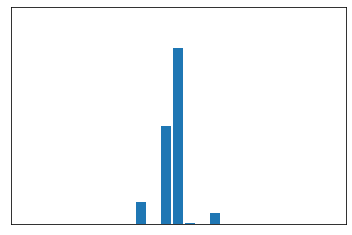

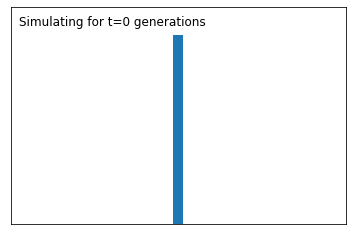

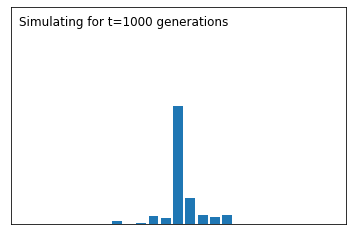

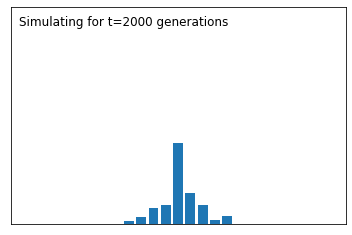

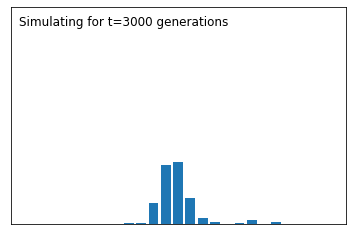

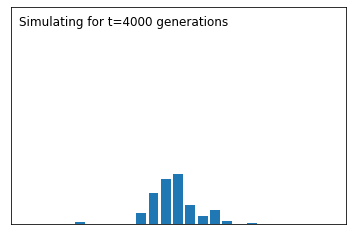

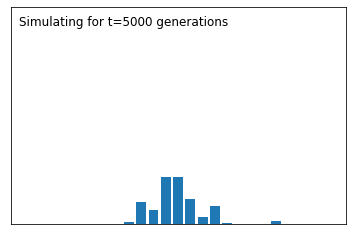

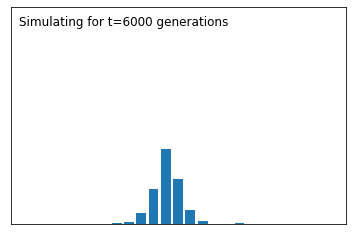

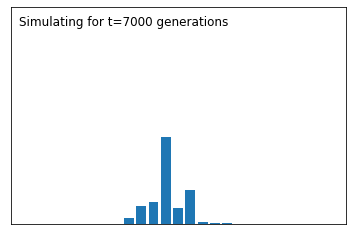

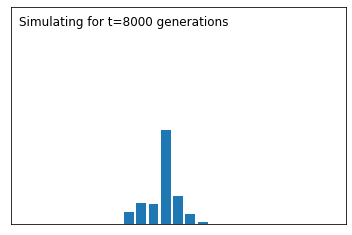

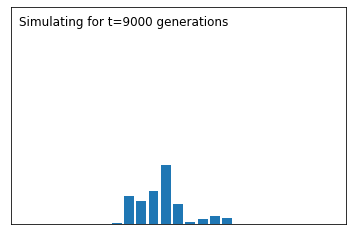

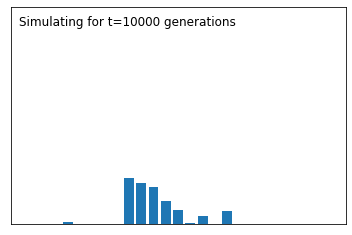

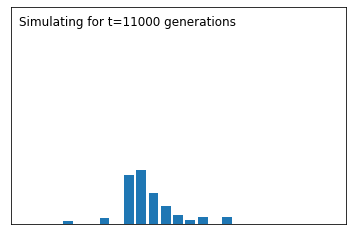

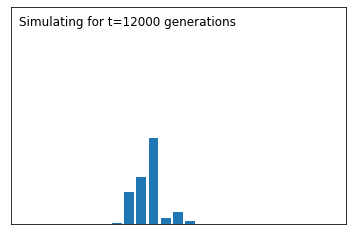

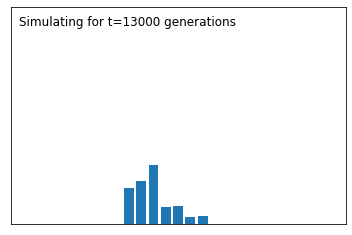

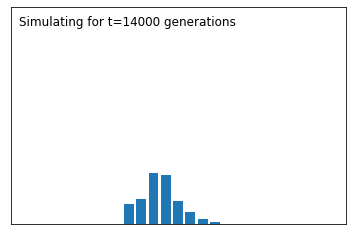

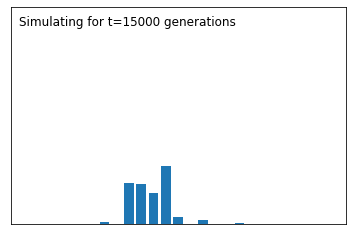

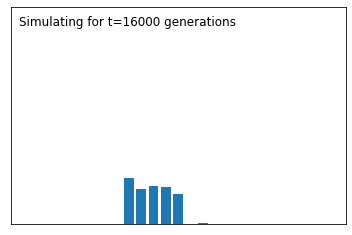

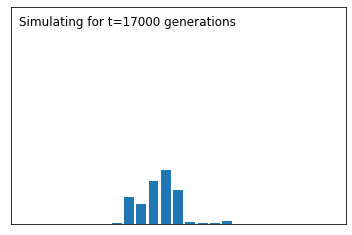

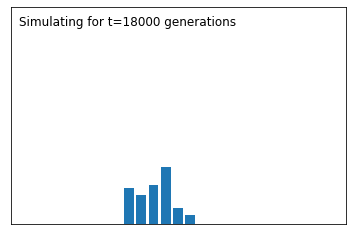

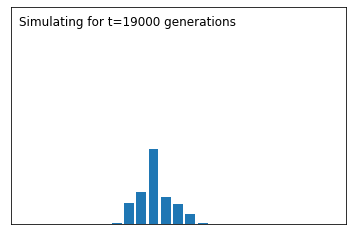

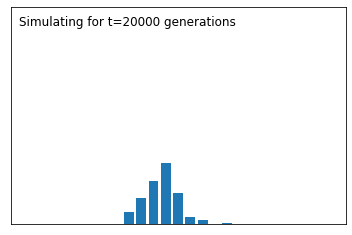

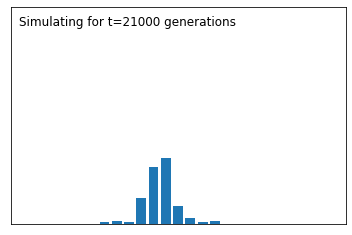

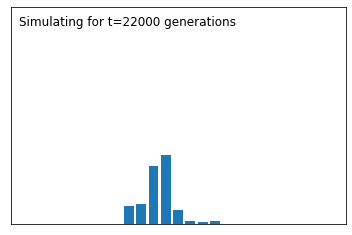

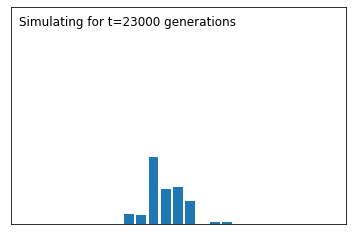

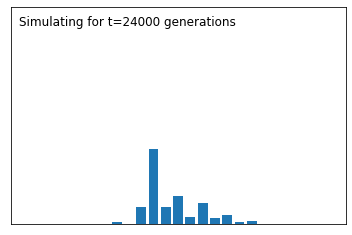

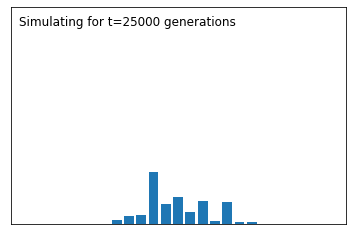

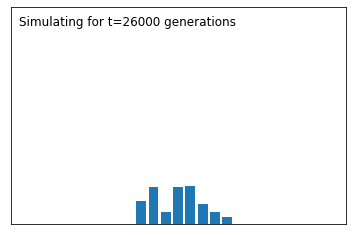

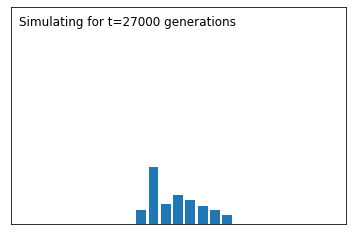

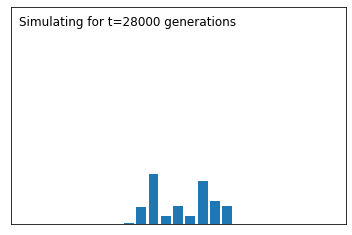

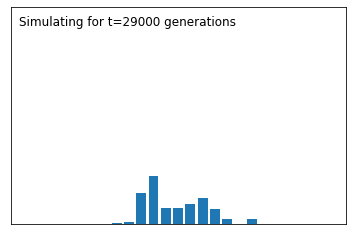

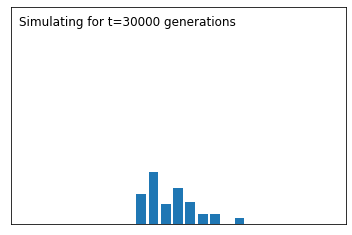

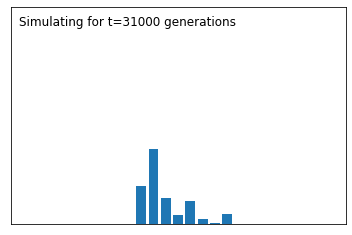

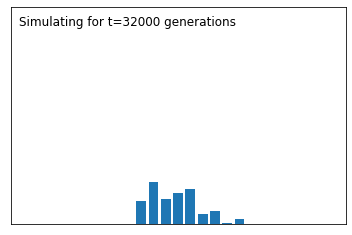

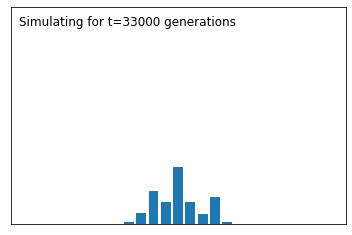

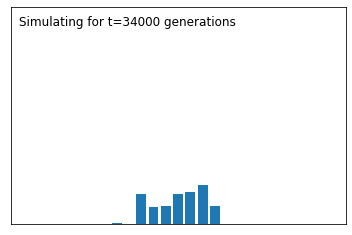

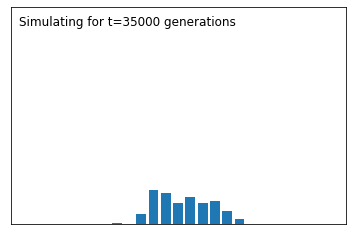

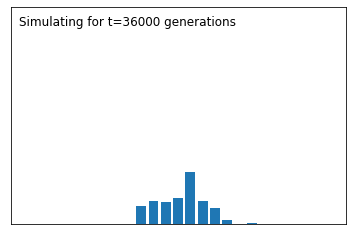

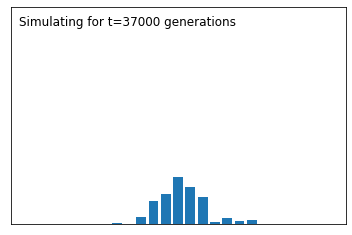

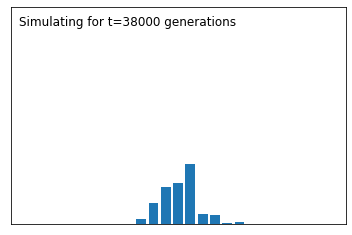

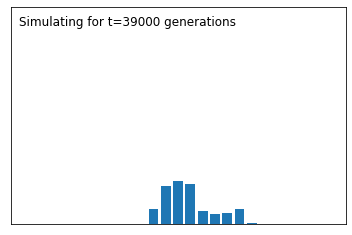

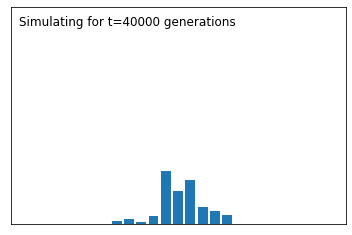

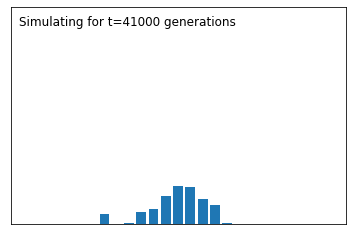

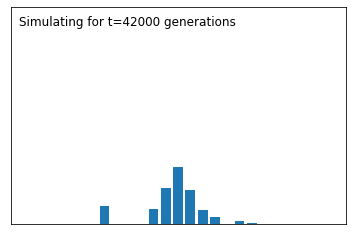

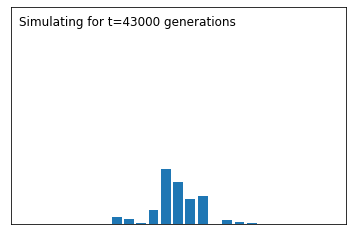

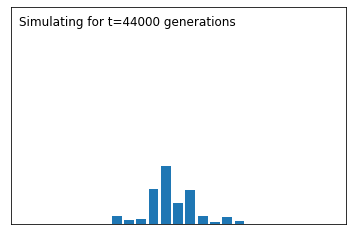

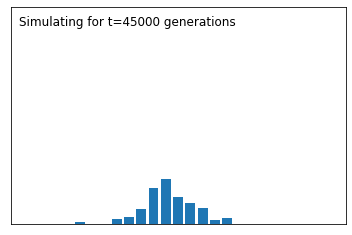

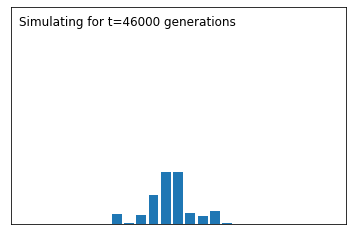

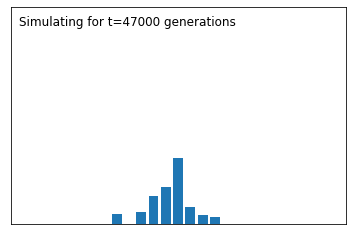

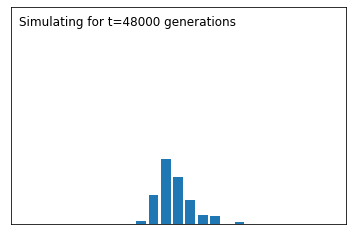

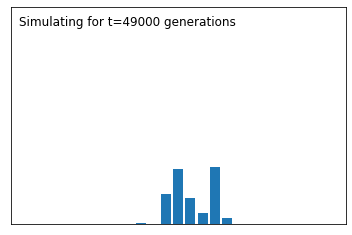

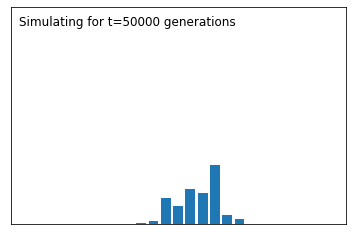

In [44]:
if __name__ == '__main__':
    main()